In [2]:
!pip install -U image-classifiers
!pip install -U efficientnet

### Mount Drive
* change working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/Research/local

/content/drive/MyDrive/Research/local


In [5]:
ls -la

total 13
-rw------- 1 root root  347 Nov  9 09:53 config.json
drwx------ 2 root root 4096 Nov  9 09:37 coreLib/
drwx------ 2 root root 4096 Nov 10 14:56 MODEL_DIR/
drwx------ 4 root root 4096 Nov 12 15:20 models/


# PARAMETERS
**BEFORE YOU START**

> Indented block


* **Kaggle dataset GCS path** from kaggle dataset
* **UPLOAD DATA CONFIG**

**SET THE FOLLOWING VARIABLES**
```python
  GCS_PATH    :    The raw path of kaggle gcs
  EPOCHS      :    number of epochs  
  BUFFER_SIZE :    shuffle size of the buffer    
  MODEL_NAME  :    name of the saved model
  TF_IDEN     :    name of the zipped folder
  DATA_FOLDER :    tfrecords folder
```

In [37]:
import os
GCS_PATH    =    'gs://kds-be7d0691e954df3457ce7220abc6cd3758f472fae588fe241aed2c3d'
MODEL_NAME  =    "seresnet152" # @param ["vgg16","vgg19","resnet18","resnet34","resnet50","resnet101","resnet152","resnet50v2","resnet101v2","resnet152v2","resnext50","resnext101","densenet121","densenet169","densenet201","inceptionv3","xception","inceptionresnetv2","seresnet18","seresnet34","seresnet50","seresnet101","seresnet152","seresnext50","seresnext101","senet154","nasnetlarge","nasnetmobile","mobilenet","mobilenetv2"]
DATA_FOLDER =    "content/drive/MyDrive/Research/tfrecords"
EPOCHS      =    250   # @param
BUFFER_SIZE =    2048
MODEL_DIR =    os.path.join(os.getcwd(),"models",f'{MODEL_NAME}')

if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,f"{MODEL_NAME}.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}'
print(GCS_PATH)
print(WEIGHT_PATH)



gs://kds-be7d0691e954df3457ce7220abc6cd3758f472fae588fe241aed2c3d/content/drive/MyDrive/Research/tfrecords
/content/drive/MyDrive/Research/local/models/seresnet152/seresnet152.h5


# Config Reading

In [38]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['algal leaf',
  'Anthracnose',
  'bird eye spot',
  'brown blight',
  'gray light',
  'healthy',
  'red leaf spot',
  'white spot'],
 'nb_channels': 3,
 'nb_classes': 8,
 'nb_eval_data': 2849,
 'nb_train_data': 7128}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [8]:
import tensorflow as tf
import os


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.15.0
Running on TPU  


REPLICAS:  8


## Training Params

In [39]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

55 22


## Data input function

In [40]:
def data_input_fn(mode):
    '''
      This Function generates data from gcs
    '''

    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))

        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

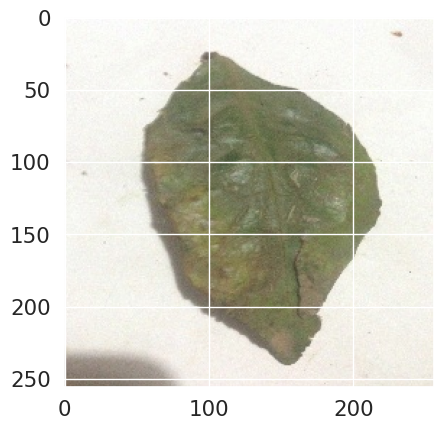

Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 8)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0.], shape=(8,), dtype=float32)


In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])

# MODEL definition
**THIS IS CHANGEABLE**

## Callbacks
**CHANGABLE**

In [42]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-10)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True,
                                                  verbose=1,
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  verbose=1,
                                                  mode = 'auto')

callbacks = [mode_autosave, lr_reducer,early_stopping ]


In [43]:
from classification_models.tfkeras import Classifiers
with strategy.scope():
    classifier, _ = Classifiers.get(MODEL_NAME)
    net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False)
    inp=net.input
    x=net.output
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
    model=tf.keras.Model(inputs=inp,outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )




model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_35 (ZeroPad  (None, 262, 262, 3)          0         ['input[0][0]']               
 ding2D)                                                                                          
                                                                                                  
 conv2d_1193 (Conv2D)        (None, 128, 128, 64)         9408      ['zero_padding2d_35[0][0]']   
                                                                                                  
 batch_normalization_104 (B  (None, 128, 128, 64)         256       ['conv2d_1193[0][0]']   

In [44]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
55/55 [==============================] - ETA: 0s - loss: 1.5934 - accuracy: 0.3411
Epoch 1: val_loss improved from inf to 5.57318, saving model to /content/drive/MyDrive/Research/local/models/seresnet152/seresnet152.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 243s 951ms/step - loss: 1.5934 - accuracy: 0.3411 - val_loss: 5.5732 - val_accuracy: 0.1737 - lr: 1.0000e-04
Epoch 2/250
55/55 [==============================] - ETA: 0s - loss: 1.2150 - accuracy: 0.4808
Epoch 2: val_loss improved from 5.57318 to 2.73994, saving model to /content/drive/MyDrive/Research/local/models/seresnet152/seresnet152.h5
55/55 [==============================] - 30s 554ms/step - loss: 1.2150 - accuracy: 0.4808 - val_loss: 2.7399 - val_accuracy: 0.1481 - lr: 1.0000e-04
Epoch 3/250
55/55 [==============================] - ETA: 0s - loss: 1.0628 - accuracy: 0.5503
Epoch 3: val_loss improved from 2.73994 to 2.52209, saving model to /content/drive/MyDrive/Research/local/models/seresnet152/seresnet152.h5
55/55 [==============================] - 34s 626ms/step - loss: 1.0628 - accuracy: 0.5503 - val_loss: 2.5221 - val_accuracy: 0.2092 - lr: 1.0000e-04
Epoch 4/250
55/55 [==============================] - ETA: 0s - loss: 0.9947 - accu

## Model history

# Results



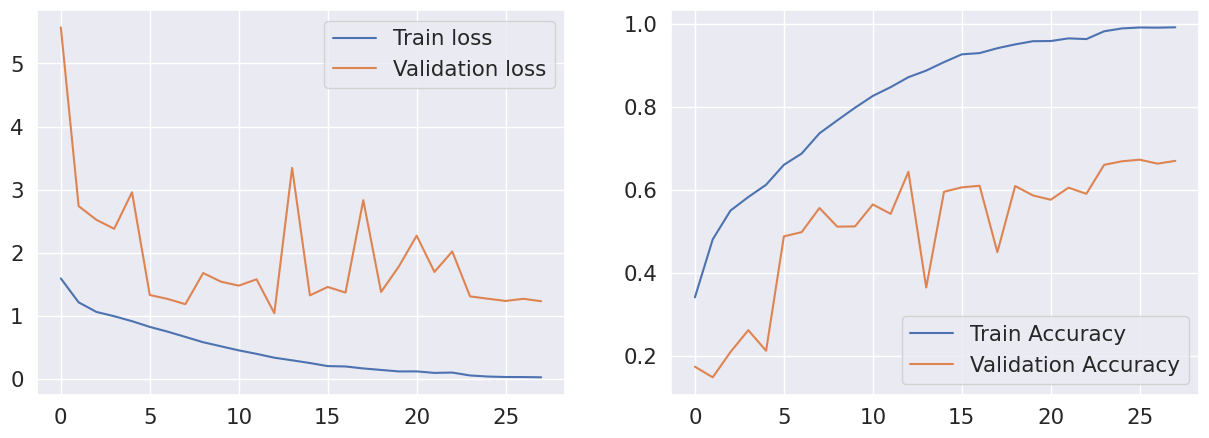

In [45]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig(os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [46]:
model.load_weights(WEIGHT_PATH)
result = model.evaluate(eval_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

22/22 [==============================] - 3s 73ms/step - loss: 1.0424 - accuracy: 0.6410


{'loss': 1.042439579963684, 'accuracy': 0.6409801244735718}

In [47]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/22 [00:00<?, ?it/s]

4/4 [==============================] - 1s 39ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

4/4 [==============================] - 1s 40ms/step


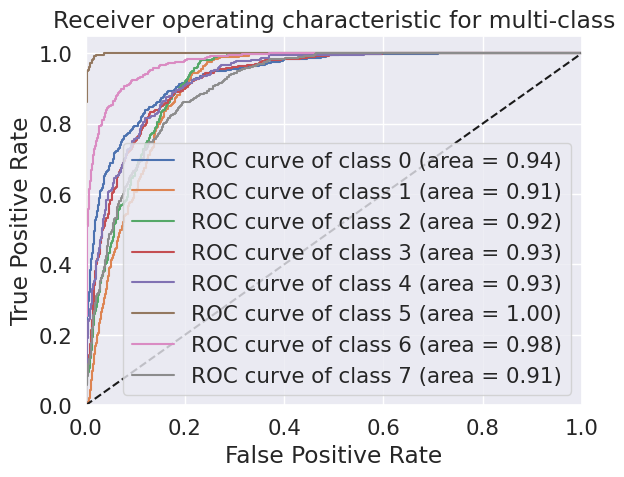

<Figure size 640x480 with 0 Axes>

In [48]:
from tqdm.auto import tqdm
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

gts=[]
preds=[]
probabilities = [] # Initialize probabilities list
images = []  # Store the image data

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred
  probabilities.append(y_pred) # Store the probabilities
  images.append(x.numpy()) # Store the image data

gts=np.array(gts)
preds=np.array(preds)
probabilities = np.concatenate(probabilities, axis=0) # Concatenate probabilities into a single array
images = np.concatenate(images, axis=0)  # Concatenate images into a single array

# Calculate ROC curve for each class
n_classes = probabilities.shape[1] # Get the number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(gts == i, probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()
plt.savefig( os.path.join(MODEL_DIR,f"roc_curve_1_{MODEL_NAME}.png"))

  0%|          | 0/22 [00:00<?, ?it/s]

4/4 [==============================] - 1s 40ms/step


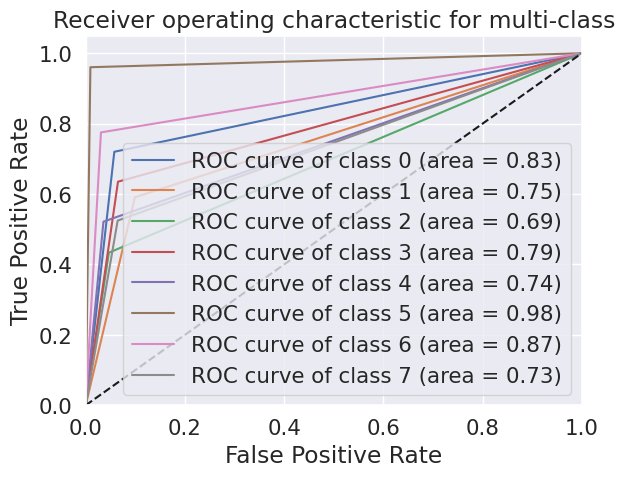

<Figure size 640x480 with 0 Axes>

In [49]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

# Convert multiclass problem to binary by selecting one class vs the rest
n_classes = 8 # Example: Assuming you have 5 classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(gts == i, preds == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()
plt.figure( os.path.join(MODEL_DIR,f"ROC_{MODEL_NAME}.png"))
plt.savefig( os.path.join(MODEL_DIR,f"roc_curve_2_{MODEL_NAME}.png"))

In [50]:
from sklearn.metrics import classification_report
print(classification_report(gts, preds, target_names=LABELS))


               precision    recall  f1-score   support

   algal leaf       0.65      0.72      0.68       368
  Anthracnose       0.42      0.59      0.49       303
bird eye spot       0.49      0.43      0.46       263
 brown blight       0.60      0.64      0.62       370
   gray light       0.66      0.52      0.58       324
      healthy       0.91      0.96      0.93       252
red leaf spot       0.83      0.78      0.80       467
   white spot       0.62      0.52      0.57       469

     accuracy                           0.64      2816
    macro avg       0.65      0.65      0.64      2816
 weighted avg       0.65      0.64      0.64      2816



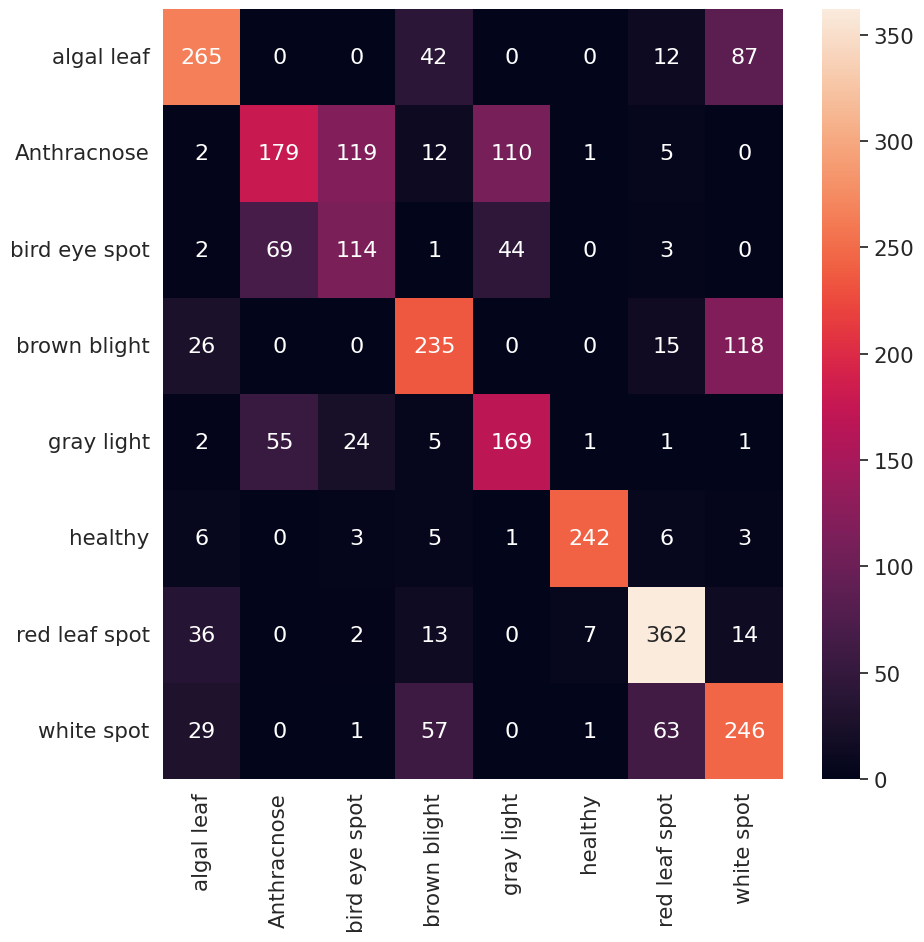

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat,
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()



